In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import vispy

sns.set(style="whitegrid")

## Loading the data and preprocessing (TFIDF)

In [2]:
# read json file

with open('rtvslo_keywords.json', encoding="utf-8") as f:
	data = json.load(f)

In [3]:
# get a list of all keywords
all_keywords = []
for d in data:
	all_keywords += d['gpt_keywords']

print(len(all_keywords))

423456


In [4]:
# get unique keywords
unique_keywords = list(set(all_keywords))
print(len(unique_keywords))

111424


In [5]:
# count the number of occurences of each keyword
keyword_counts = {keyword: 0 for keyword in unique_keywords}

for keyword in all_keywords:
	keyword_counts[keyword] += 1

# keep only keywords that appear at least 20 times
keyword_counts_filtered = {k: v for k, v in keyword_counts.items() if v >= 20}

print(len(keyword_counts_filtered))

3058


In [6]:
# count how many keywords appear in each article
keyword_appearances = [len(d['gpt_keywords']) for d in data]

In [7]:
# sort keywords by frequency
sorted_keywords = sorted(keyword_counts_filtered, key=keyword_counts_filtered.get, reverse=True)

In [8]:
# appearances of keywords in documents
attributes = np.zeros((len(data), len(sorted_keywords)), dtype=float)

for i, d in enumerate(data):
	for keyword in d['gpt_keywords']:
		if keyword in sorted_keywords:
			j = sorted_keywords.index(keyword)
			attributes[i, j] = 1

In [9]:
# do TF-IDF transformation

# compute the term frequency
tf = attributes / np.array(keyword_appearances)[:, None]

# compute the inverse document frequency
df = np.sum(attributes > 0, axis=0)
idf = np.log(attributes.shape[0] / df)

# compute the TF-IDF
tfidf = tf * idf

In [10]:
# center the data
tfidf = tfidf - np.mean(tfidf, axis=0)

## PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(tfidf)

tfidf_pca = pca.transform(tfidf)

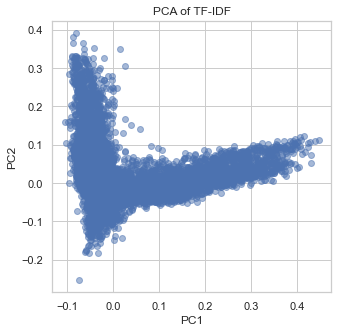

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of TF-IDF')
plt.show()

In [146]:
# list most important keywords for each PC

for i in range(3):
	important_keywords = np.argsort(pca.components_[i])[-8:]
	print(f'++ PC {i+1}: {", ".join([sorted_keywords[j] for j in important_keywords])}')
	negative_keywords = np.argsort(pca.components_[i])[:8]
	print(f'-- PC {i+1}: {", ".join([sorted_keywords[j] for j in negative_keywords])}')

++ PC 1: obramba, gol, točke, poraz, ekipa, trener, zmaga, tekma
-- PC 1: vlada, varnost, politika, zakon, policija, vojna, Ukrajina, premier
++ PC 2: vojska, Hamas, napad, konflikt, vojna, Rusija, Ukrajina, Izrael
-- PC 2: umetnost, glasba, razstava, festival, nagrada, koncert, film, kultura
++ PC 3: koalicija, zakonodaja, parlament, premier, politika, volitve, zakon, vlada
-- PC 3: umetnost, Izrael, vojna, Hamas, glasba, konflikt, razstava, festival


In [501]:
important_keywords = []
number_of_each = 3
for i in range(3):
	important_keywords += list(np.argsort(pca.components_[i])[-number_of_each:])
	important_keywords += list(np.argsort(pca.components_[i])[:number_of_each])

In [502]:
important_keywords = list(set(important_keywords))
important_keywords

[1, 2, 4, 5, 37, 7, 8, 11, 12, 43, 15, 19, 26, 27, 31]

In [503]:
important_keywords = list(set(important_keywords + [i for i in range(9)]))

important_keywords_texts = [sorted_keywords[j] for j in important_keywords]

# create a new dataset with samples for the most important keywords
important_keywords_samples = np.zeros((len(data), len(sorted_keywords)), dtype=float)
for i, keyword in enumerate(important_keywords):
	important_keywords_samples[i, keyword] = 1

print(len(important_keywords_texts))
print(important_keywords_texts)
print(important_keywords)

18
['Slovenija', 'zmaga', 'tekma', 'ekipa', 'vlada', 'razstava', 'varnost', 'trener', 'Ukrajina', 'ZDA', 'Rusija', 'umetnost', 'volitve', 'zakon', 'politika', 'Izrael', 'vojna', 'glasba']
[0, 1, 2, 3, 4, 37, 5, 7, 8, 6, 11, 12, 43, 15, 19, 26, 27, 31]


In [504]:
important_keywords_samples_pca = pca.transform(important_keywords_samples)

In [157]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.
    
    From https://stackoverflow.com/questions/13685386/how-to-set-the-equal-aspect-ratio-for-all-axes-x-y-z

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

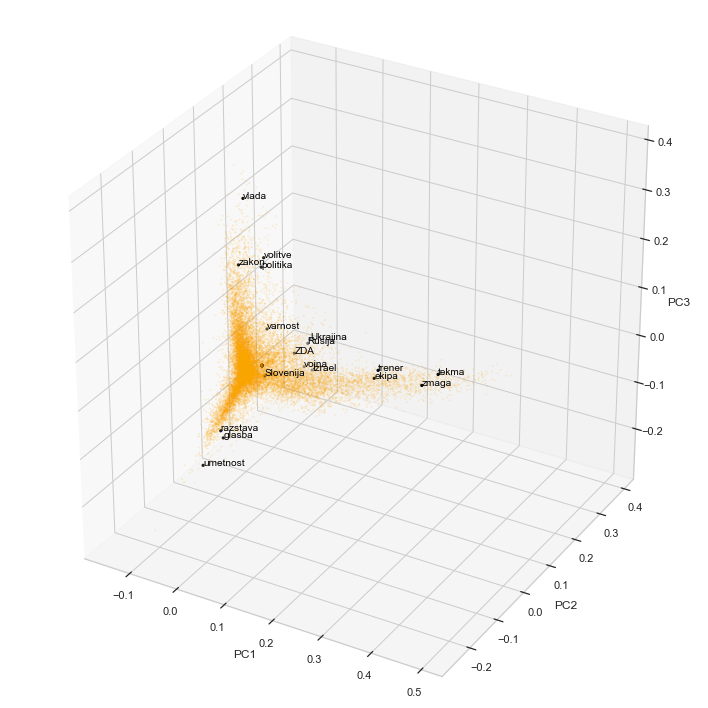

In [221]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(tfidf_pca[:, 0], tfidf_pca[:, 1], tfidf_pca[:, 2], alpha=0.1, color='orange', s=1)

ax.scatter(important_keywords_samples_pca[:, 0], important_keywords_samples_pca[:, 1], important_keywords_samples_pca[:, 2], color='black', s=5)

for i, txt in enumerate(important_keywords_texts):
	ax.text(important_keywords_samples_pca[i, 0], important_keywords_samples_pca[i, 1], important_keywords_samples_pca[i, 2], txt, color='black', fontsize=10)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# change view angle
# ax.view_init(elev=30, azim=300)

# axis equal
ax.set_box_aspect([1,1,1])

set_axes_equal(ax)

plt.tight_layout()
# plt.show()

plt.savefig('pca.svg', dpi=300)

---
## t-SNE

In [197]:
from sklearn.manifold import TSNE

np.random.seed(1011)
pca = PCA(n_components=100)
pca.fit(tfidf)
tfidf_pca2 = pca.transform(tfidf)


In [ ]:
np.random.seed(1011)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, verbose=2)
tfidf_tsne = tsne.fit_transform(tfidf_pca2)

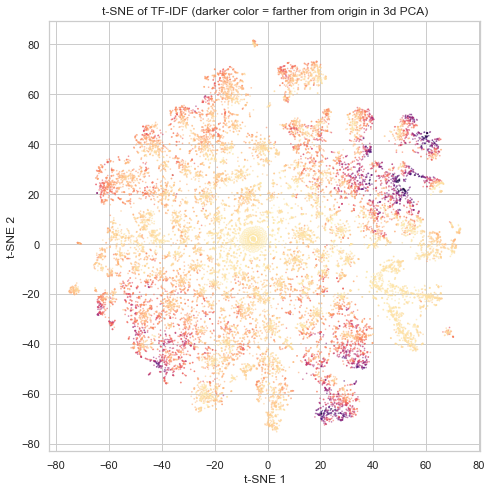

In [230]:
plt.figure(figsize=(7, 7))

plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], alpha=0.5, c=np.sqrt(tfidf_pca2[:, 0]**2 + tfidf_pca2[:, 1]**2 + tfidf_pca2[:, 2]**2) , cmap='magma_r', s=0.5)


plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of TF-IDF (darker color = farther from origin in 3d PCA)')


plt.tight_layout()

# plt.show()
plt.savefig('tsnec.png', dpi=300)

### k-means

In [505]:
from sklearn.cluster import KMeans

n_clusters = 20

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(tfidf_tsne)

In [506]:
# number of occurances of each keyword in each cluster
keyword_cluster_counts = np.zeros((len(sorted_keywords), n_clusters), dtype=int)

for i in range(n_clusters):
	cluster_indices = np.where(kmeans.labels_ == i)[0]
	cluster_keywords = np.sum(attributes[cluster_indices], axis=0)
	keyword_cluster_counts[:, i] = cluster_keywords


# tf-idf of each keyword in each cluster
tf_cluster = keyword_cluster_counts / np.sum(keyword_cluster_counts, axis=0)
df_cluster = np.sum(keyword_cluster_counts > 0, axis=1)
idf_cluster = np.log(keyword_cluster_counts.shape[1] / df_cluster)


tfidf_cluster = tf_cluster * idf_cluster[:, None]


for i in range(n_clusters):
	important_keywords = np.argsort(tfidf_cluster[:, i])[-5:]
	print(f'Cluster {i}: {", ".join([sorted_keywords[j] for j in important_keywords])}')


Cluster 0: toplogredni plini, poplave, vročinski val, podnebne spremembe, globalno segrevanje
Cluster 1: roman, književnost, premiera, poezija, literatura
Cluster 2: DZ, zakon, zakonodaja, volitve, vlada
Cluster 3: Peter Prevc, veleslalom, tenis, ATP, svetovni pokal
Cluster 4: Košarka, Gol, Real Madrid, Manchester City, Tekma
Cluster 5: ločitev, turisti, turizem, igralec, prenočitve
Cluster 6: zaporna kazen, kaznivo dejanje, tožilec, volitve, policija
Cluster 7: Izraelska vojska, Gazo, Palestinci, talci, Hamas
Cluster 8: svetovno prvenstvo, kvalifikacije, selektor, evropsko prvenstvo, reprezentanca
Cluster 9: Fed, javni sektor, prihodki, obrestne mere, inflacija
Cluster 10: Remco Evenepoel, sprint, dirka, Tadej Pogačar, etapa
Cluster 11: protiofenziva, Kremlj, vojaška pomoč, Vladimir Putin, Volodimir Zelenski
Cluster 12: zaposlovanje, razpis, prenova, javno naročilo, ministrstvo
Cluster 13: raketa, populacija, diagnoza, narava, vesolje
Cluster 14: gol, končnica, poraz, vratar, točke
Cl

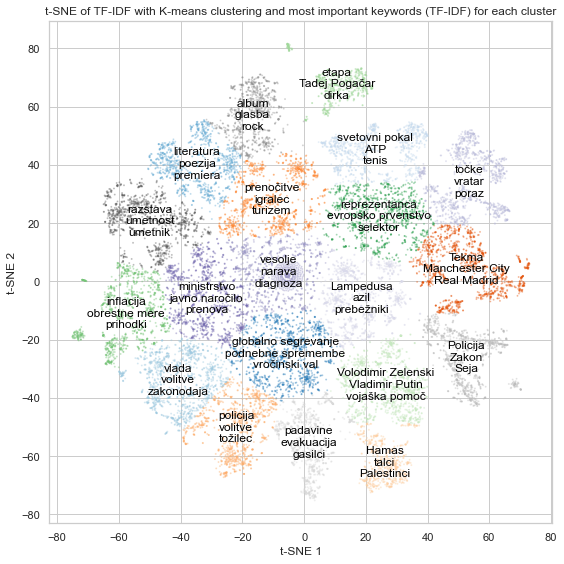

In [507]:
# plot the most important keywords for each cluster at its center
offset = 4

cluster_centers = kmeans.cluster_centers_

plt.figure(figsize=(8, 8))

plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], alpha=0.3, c=kmeans.labels_, cmap='tab20c', s=1)

for i in range(n_clusters):
	most_important = np.argsort(tfidf_cluster[:, i])[-3:]
	plt.text(cluster_centers[i, 0], cluster_centers[i, 1] + offset, sorted_keywords[most_important[-1]], fontsize=12, color='black', ha='center', va='center')
	plt.text(cluster_centers[i, 0], cluster_centers[i, 1]         , sorted_keywords[most_important[-2]], fontsize=12, color='black', ha='center', va='center')
	plt.text(cluster_centers[i, 0], cluster_centers[i, 1] - offset, sorted_keywords[most_important[-3]], fontsize=12, color='black', ha='center', va='center')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of TF-IDF with K-means clustering and most important keywords (TF-IDF) for each cluster')

plt.tight_layout()

# plt.show()
plt.savefig('tsne_kmeans.png', dpi=300)

### DBSCAN

In [497]:
from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=2.7, min_samples=30).fit(tfidf_tsne)
dbscan = DBSCAN(eps=3.0, min_samples=40).fit(tfidf_tsne)

In [498]:
dbscan.labels_.max()

30

In [499]:
# number of occurances of each keyword in each cluster
n_clusters = dbscan.labels_.max() + 1

keyword_cluster_counts = np.zeros((len(sorted_keywords), n_clusters), dtype=int)

for i in range(n_clusters):
	cluster_indices = np.where(dbscan.labels_ == i)[0]
	cluster_keywords = np.sum(attributes[cluster_indices], axis=0)
	keyword_cluster_counts[:, i] = cluster_keywords


# tf-idf of each keyword in each cluster
tf_cluster = keyword_cluster_counts / np.sum(keyword_cluster_counts, axis=0)
df_cluster = np.sum(keyword_cluster_counts > 0, axis=1)
idf_cluster = np.log(keyword_cluster_counts.shape[1] / df_cluster)


tfidf_cluster = tf_cluster * idf_cluster[:, None]


for i in range(n_clusters):
	important_keywords = np.argsort(tfidf_cluster[:, i])[-5:]
	print(f'Cluster {i}: {", ".join([sorted_keywords[j] for j in important_keywords])}')


Cluster 0: NBA, Cedevita Olimpija, podaje, točke, košarka
Cluster 1: zakon, policija, DZ, zakonodaja, ministrstvo
Cluster 2: trener, poraz, tekma, vratar, gol
Cluster 3: Pjongjang, Severna Koreja, republikanci, Donald Trump, Joe Biden
Cluster 4: družbena omrežja, zveza, poroka, ločitev, otroci
Cluster 5: Seja, Ministrstvo, Zakon, Vlada, Policija
Cluster 6: tekmovanje, tekma, evropsko prvenstvo, reprezentanca, svetovni pokal
Cluster 7: Primož Roglič, sprint, Tadej Pogačar, etapa, dirka
Cluster 8: Kremlj, Volodimir Zelenski, Vladimir Putin, Ukrajina, Rusija
Cluster 9: premiera, festival, koncert, glasba, album
Cluster 10: turnir, niz, grand slam, ATP, tenis
Cluster 11: civilna zaščita, požar, gasilci, evakuacija, padavine
Cluster 12: stranka, politika, koalicija, opozicija, volitve
Cluster 13: obalna straža, prebežniki, Tunizija, Lampedusa, Italija
Cluster 14: cene, baterija, prodaja, proizvodnja, tehnologija
Cluster 15: zgodovina, slikarstvo, umetnik, umetnost, razstava
Cluster 16: prev

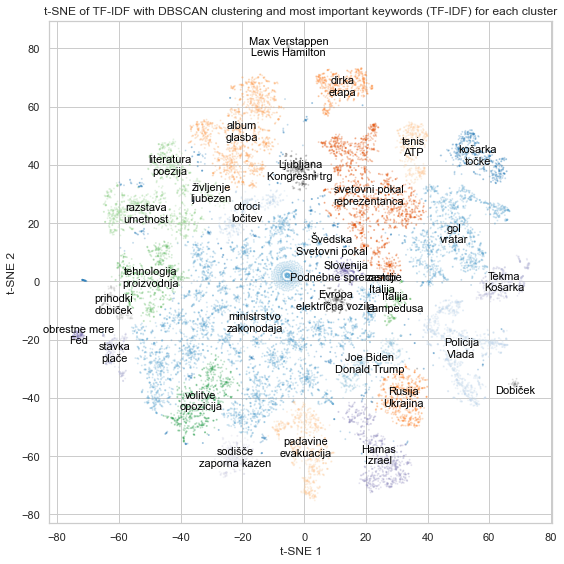

In [500]:
offset = 2

cluster_centers = np.array([np.mean(tfidf_tsne[np.where(dbscan.labels_ == i)], axis=0) for i in range(n_clusters)])

plt.figure(figsize=(8, 8))

plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], alpha=0.2, c=dbscan.labels_, cmap='tab20c', s=1)

for i in range(n_clusters):
	most_important = np.argsort(tfidf_cluster[:, i])[-2:]
	plt.text(cluster_centers[i, 0], cluster_centers[i, 1] + offset, sorted_keywords[most_important[-1]], fontsize=11, color='black', ha='center', va='center')
	plt.text(cluster_centers[i, 0], cluster_centers[i, 1] - offset, sorted_keywords[most_important[-2]], fontsize=11, color='black', ha='center', va='center')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE of TF-IDF with DBSCAN clustering and most important keywords (TF-IDF) for each cluster')

plt.tight_layout()

# plt.show()

plt.savefig('tsne_dbscan.png', dpi=300)